In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd

In [2]:
print(tf.version.VERSION)

2.6.2


In [3]:
dataset_path = os.listdir('../input/pruned/pruned_images')

print(dataset_path)

print(len(dataset_path))

['thyme', 'rosemary', 'sage', 'basil', 'spearmint', 'oregano']
6


In [4]:
class_labels = []

for item in dataset_path:
    all_classes = os.listdir('../input/pruned/pruned_images' + '/' + item)
    
    for room in all_classes:
        class_labels.append((item, str('dataset_path' + '/' + item) + '/' + room))

In [5]:
df = pd.DataFrame(data=class_labels, columns=['labels', 'image'])
print(df.head())
print(df.tail())

  labels                            image
0  thyme  dataset_path/thyme/image233.jpg
1  thyme  dataset_path/thyme/image920.jpg
2  thyme  dataset_path/thyme/image752.jpg
3  thyme  dataset_path/thyme/image571.jpg
4  thyme  dataset_path/thyme/image596.jpg
       labels                               image
2876  oregano  dataset_path/oregano/image7029.jpg
2877  oregano  dataset_path/oregano/image2238.jpg
2878  oregano  dataset_path/oregano/image8560.jpg
2879  oregano  dataset_path/oregano/image2287.jpg
2880  oregano  dataset_path/oregano/image2208.jpg


In [6]:
import cv2

path = '../input/pruned/pruned_images/'
dataset_path = os.listdir('../input/pruned/pruned_images')

IMG_SIZE = 224

images = []
labels = []

for i in dataset_path:
    data_path = path + str(i)
    print(data_path)
    filenames = [i for i in os.listdir(data_path)]
    
    for f in filenames:
        img = cv2.imread(data_path + '/' + f)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        images.append(img)
        labels.append(i)

../input/pruned/pruned_images/thyme
../input/pruned/pruned_images/rosemary
../input/pruned/pruned_images/sage
../input/pruned/pruned_images/basil
../input/pruned/pruned_images/spearmint
../input/pruned/pruned_images/oregano


In [7]:
images = np.array(images)

images = images.astype('float32')
# print(images.shape)
# print(labels)

In [8]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

y = df['labels'].values
print(y)
# for h in y:
#     print(h)

y_labelencoder = LabelEncoder()
y = y_labelencoder.fit_transform(y)
print(y)
# for h in y:
#     print(h)

['thyme' 'thyme' 'thyme' ... 'oregano' 'oregano' 'oregano']
[5 5 5 ... 1 1 1]


In [9]:
y = y.reshape(-1,1)

from sklearn.compose import ColumnTransformer

ct = ColumnTransformer([('my_ohe', OneHotEncoder(), [0])], remainder='passthrough')
Y = ct.fit_transform(y).toarray()

Y = np.array(Y)

Y = np.argmax(Y, axis=1)

print(Y.shape)

(2881,)


In [10]:
dataset = tf.data.Dataset.from_tensor_slices((images, Y) )
print(dataset)
# for element in dataset.take(1):
#   print(element)

2022-01-26 14:33:24.515912: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 14:33:24.644459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 14:33:24.645356: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 14:33:24.648108: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

<TensorSliceDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>


In [11]:
dataset = dataset.shuffle(buffer_size = 2048)
ds_train = dataset.take(round(0.8*len(dataset)))
ds_test = dataset.skip(round(0.8*len(dataset)))

In [12]:
print(len(ds_train))
print(len(ds_test))

2305
576


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)


In [14]:
# One-hot / categorical encoding

NUM_CLASSES = 6
batch_size = 64

def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

print(ds_train)

ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)

print(ds_train)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

<TakeDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>
<ParallelMapDataset shapes: ((224, 224, 3), (6,)), types: (tf.float32, tf.float32)>


In [15]:
def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * tf.math.exp(-0.028)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                patience = 25, 
                                mode='auto', 
                                restore_best_weights=True)

In [16]:
from tensorflow.keras.applications import EfficientNetB0
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [17]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


16719872/16705208 [==============================] - 0s 0us/step


2022-01-26 14:33:33.249158: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1734684672 exceeds 10% of free system memory.
2022-01-26 14:33:34.890478: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-26 14:33:34.928784: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1734684672 exceeds 10% of free system memory.


Epoch 1/10


2022-01-26 14:33:42.876601: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


36/36 [==============================] - ETA: 0s - loss: 1.4601 - accuracy: 0.6272

2022-01-26 14:33:50.967960: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1734684672 exceeds 10% of free system memory.


36/36 [==============================] - 20s 233ms/step - loss: 1.4601 - accuracy: 0.6272 - val_loss: 1.2187 - val_accuracy: 0.5052
Epoch 2/10
36/36 [==============================] - 7s 193ms/step - loss: 1.1477 - accuracy: 0.7339 - val_loss: 0.8289 - val_accuracy: 0.6875
Epoch 3/10
36/36 [==============================] - 7s 194ms/step - loss: 1.0067 - accuracy: 0.7383 - val_loss: 0.5930 - val_accuracy: 0.7743
Epoch 4/10
36/36 [==============================] - 7s 204ms/step - loss: 0.9116 - accuracy: 0.7600 - val_loss: 0.6828 - val_accuracy: 0.7535
Epoch 5/10
36/36 [==============================] - 7s 200ms/step - loss: 0.8997 - accuracy: 0.7587 - val_loss: 0.5216 - val_accuracy: 0.8177
Epoch 6/10
36/36 [==============================] - 7s 199ms/step - loss: 0.8973 - accuracy: 0.7661 - val_loss: 0.5058 - val_accuracy: 0.8264
Epoch 7/10
36/36 [==============================] - 7s 193ms/step - loss: 0.8251 - accuracy: 0.7730 - val_loss: 0.5305 - val_accuracy: 0.8264
Epoch 8/10
36/36

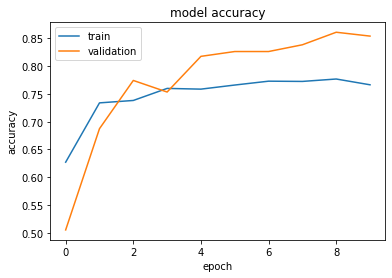

In [18]:
model = build_model(num_classes=NUM_CLASSES)

epochs = 10
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=1) #, callbacks=[callback, lr_schedule])
plot_hist(hist)

In [19]:
from sklearn import metrics
ds_unbatch = ds_test.unbatch().batch(1)

print(ds_unbatch)
pred = []
y_test = []
for i, data in enumerate(ds_unbatch):
    pred.append(np.argmax(model.predict(data[0]), axis=1))
    y_test.append(np.argmax(data[1], axis=1))

# Print confusion matrix
print(metrics.confusion_matrix(y_test, pred))

<BatchDataset shapes: ((None, 224, 224, 3), (None, 6)), types: (tf.float32, tf.float32)>
[[ 90   3   0   2   3   0]
 [  1 109   0   4   7   1]
 [  0   0  81   3   1   3]
 [  0   5   1  76   2   0]
 [  1   6   4   1  75   1]
 [  1  15   3   5   2  70]]


In [20]:
print(len(ds_unbatch))

576


In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
model_tflite = converter.convert()
file = open("model.tflite", "wb").write(model_tflite)

2022-01-26 14:36:04.400386: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-01-26 14:36:25.403009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 14:36:25.403403: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-01-26 14:36:25.403538: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-01-26 14:36:25.404064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.

In [22]:
model.save('E_NET_B0_DEFAULT.h5')

In [23]:
from tensorflow import keras
model_loaded = keras.models.load_model('E_NET_B0_DEFAULT.h5')

In [24]:
import cv2
import tensorflow as tf
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn import metrics


categ = ['basil', 'oregano', 'rosemary', 'sage', 'spearmint', 'thyme']


IMG_SIZE = 224
img_path = ('../input/pruned/pruned_images/basil/image100.jpg')

img = cv2.imread(img_path)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))


x = (img.astype(np.float32))       
# # x = np.expand_dims(img, axis=0)
# # print(x[1,:,:])

vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
print()
print(x.shape)
pp = np.zeros(x.shape)
for i in range(3):
    for j in range(224):
        for k in range(224):
            pp[k,j,i] = x[k,j,i] - vgg_mean[i]

x[:,:,0] = pp[:,:,2]
x[:,:,1] = pp[:,:,1]
x[:,:,2] = pp[:,:,0]


x = np.expand_dims(x, axis=0)
# print(x[:,:,1,:])

# print()

t = preprocess_input(np.expand_dims(img, axis=0))
print(np.array_equal(x,t))



# print('Input image shape: ', x.shape)
            
# my_image = imread(img_path)
# imshow(img)

# pred = model_loaded.predict(x)

# print(pred)
# classification = np.argmax(pred[0])
# print(classification)
# print(categ[classification])


(224, 224, 3)
True


In [25]:
interpreter = tf.lite.Interpreter('./model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
# print(input_details)
output_details = interpreter.get_output_details()

input_shape=input_details[0]['shape']
#input_data= np.array(np.random.random_sample(input_shape), dtype=np.float32
input_data = x
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
pred = np.argmax(output_data, axis=1)
print(int(pred))
print(categ[int(pred)])

0
basil


In [26]:
path = '../input/d/gabrielhauss/testing-loading-predicting/frameee.jpg'

def cropImg(path, num, IMG_SIZE):
    img_array = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    crop_img = img_array[0:700, 160:870]
    if(num==1):
        img1 = crop_img[0:300, 0:350]
#         imshow(img1)
        return cv2.resize(img1, (IMG_SIZE, IMG_SIZE)).astype(np.float32)
    if(num==3):
        img2 = crop_img[380:700, 0:250]
#         imshow(img2)
        return cv2.resize(img2, (IMG_SIZE, IMG_SIZE)).astype(np.float32)
    if(num==2):
        img3 = crop_img[0:320, 380:800]
#         imshow(img3)
        return cv2.resize(img3, (IMG_SIZE, IMG_SIZE)).astype(np.float32)
    if(num==4):
        img4 = crop_img[380:700, 400:800]
#         imshow(img4)
        return cv2.resize(img4, (IMG_SIZE, IMG_SIZE)).astype(np.float32)

In [27]:
interpreter = tf.lite.Interpreter('./model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
print(input_details)
output_details = interpreter.get_output_details()

input_shape=input_details[0]['shape']


vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))

x = cropImg(path,1 , IMG_SIZE)
            
pp = np.zeros(x.shape)
for i in range(3):
    for j in range(len(x)):
        for k in range(len(x)):
            pp[k,j,i] = x[k,j,i] - vgg_mean[i]

x[:,:,0] = pp[:,:,2]
x[:,:,1] = pp[:,:,1]
x[:,:,2] = pp[:,:,0]


x = np.expand_dims(x, axis=0)

input_data = x

input_data = interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
pred = np.argmax(output_data, axis=1)
print(int(pred))
print(categ[int(pred)])

[{'name': 'input_1', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
0
basil
